# Week 5. Complex model and metrics
Cognitive Systems for Health Technology Applications<br>
Sakari Lukkarinen & Juha Kopu, 11.2.2108<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi)

## Objectives

The aim of this study is to experiment with the complex convolutional neural network to solve the diabetic retinopathy classification problem and calculate some test metrics. The idea of the model is based on Chollet's example 5.3.

## Build the model

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


In [2]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [3]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [4]:
conv_base.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


## Train the model

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = "..\\..\\dataset2\\train"
validation_dir = "..\\..\\dataset2\\validation"
test_dir = "..\\..\\dataset2\\test"

train_datagen = ImageDataGenerator(
      rescale=1./255,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

import time

t1 = time.time()

history = model.fit_generator(
      train_generator,
      steps_per_epoch=62,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=21,
      verbose=0)

t2 = time.time()

model.save('Case 2 combined.h5')

Found 1237 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


In [7]:
print('Elapsed time {:.2f} hours.'.format((t2-t1)/3600))
print('Time per epoch {:.2f} minutes.'.format((t2-t1)/50/60))

Elapsed time 22.12 hours.
Time per epoch 26.54 minutes.


## Results

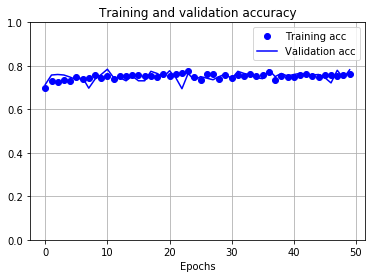

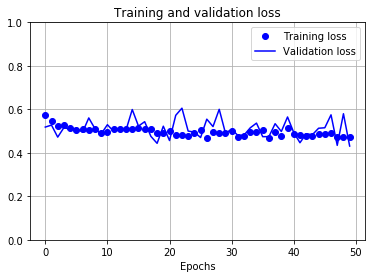

In [64]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylim([0, 1])
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylim([0, 1])
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

## Test the model

In [17]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

r = model.evaluate_generator(test_generator, steps = 21)

# Loss and accuracy
r

Found 413 images belonging to 2 classes.


[0.52644581436100657, 0.72397094777363558]

### Predict the score

In [16]:
import numpy as np

y_true = np.zeros(413)
y_score = np.zeros(413)
sample_count = 413
i = 0
for inputs_batch, labels_batch in test_generator:
        predicts_batch = model.predict(inputs_batch)
        L = labels_batch.shape[0]
        index = range(i, i + L)
        y_true[index] = labels_batch.ravel()
        y_score[index] = predicts_batch.ravel()
        i = i + L
        if i >= sample_count:
            break

### Calculate ROC and AUC

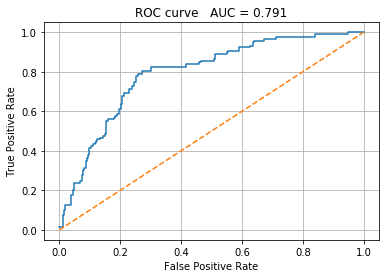

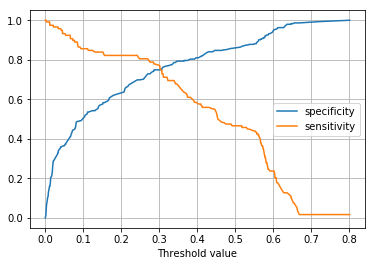

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve   AUC = {:.3f}'.format(auc))
plt.show()

plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

### Calculate the metrics

In [67]:
# http://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [68]:
# Select the threshold to maximize both specificity and sensitivity
th = 0.3

In [69]:
acc = accuracy_score(y_true, y_score > th)
prec = precision_score(y_true, y_score > th)
f1 = f1_score(y_true, y_score > th)
recall = recall_score(y_true, y_score > th)

print('Accuracy:  {:.3f}'.format(acc))
print('Precision: {:.3f}'.format(prec))
print('Recall:    {:.3f}'.format(recall))
print('F1:        {:.3f}'.format(f1))

Accuracy:  0.755
Precision: 0.552
Recall:    0.771
F1:        0.643


In [70]:
print('Classification report')
print(classification_report(y_true, y_score > th, labels = [1.0, 0.0], target_names = ['Disease', 'Healthy']))

Classification report
             precision    recall  f1-score   support

    Disease       0.55      0.77      0.64       118
    Healthy       0.89      0.75      0.81       295

avg / total       0.79      0.76      0.77       413



In [97]:
tn, fp, fn, tp = confusion_matrix(y_true, y_score > th).ravel()

print('                      Confusion matrix')
print('                       True condition')
print('                      Positive Negative      Sum')
print('Predicted | Positive  {:8} {:8} {:8}'.format(tp, fp, tp + fp))
print('condition | Negative  {:8} {:8} {:8}'.format(fn, tn, fn + tn))
print('                 Sum  {:8} {:8} {:8}'.format(tp + fn, fp + tn, tp + fp + fn + tn))
print(' ')
print('Sensitivity: {:.3f}'.format(tp/(tp+fn)))
print('Specificity: {:.3f}'.format(tn/(tn+fp)))

                      Confusion matrix
                       True condition
                      Positive Negative      Sum
Predicted | Positive        91       74      165
condition | Negative        27      221      248
                 Sum       118      295      413
 
Sensitivity: 0.771
Specificity: 0.749


Sensitivity refers to the test's ability to correctly detect ill patients who do have the condition.<br>
Specificity relates to the test's ability to correctly reject healthy patients without a condition. 

In [82]:
help(confusion_matrix)
# help(classification_report)
# https://en.wikipedia.org/wiki/Sensitivity_and_specificity
# https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)

Help on function confusion_matrix in module sklearn.metrics.classification:

confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)
    Compute confusion matrix to evaluate the accuracy of a classification
    
    By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
    is equal to the number of observations known to be in group :math:`i` but
    predicted to be in group :math:`j`.
    
    Thus in binary classification, the count of true negatives is
    :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
    :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.
    
    Read more in the :ref:`User Guide <confusion_matrix>`.
    
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (correct) target values.
    
    y_pred : array, shape = [n_samples]
        Estimated targets as returned by a classifier.
    
    labels : array, shape = [n_classes], optional
        List of labels to index the m